In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
# ==========================================
# 1. SETUP AND LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Preprocessing & Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Settings for cleaner output
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

print("Libraries Imported Successfully")

Libraries Imported Successfully


In [8]:

# ==========================================
# 2. DATA LOADING & CLEANING
# ==========================================
# Robust loading: Handles both Excel and CSV formats found on Kaggle
try:
    df = pd.read_excel('/kaggle/input/online-retail/Online Retail.xlsx')
    print("Loaded using Excel reader.")
except:
    df = pd.read_csv('/kaggle/input/online-retail/OnlineRetail.csv', encoding='ISO-8859-1')
    print("Loaded using CSV reader.")

# Drop missing CustomerIDs (Crucial for segmentation)
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Clean: Remove cancelled transactions (InvoiceNo starts with 'C') and negative quantities
df = df[~df['InvoiceNo'].astype(str).str.contains('C')]
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Calculate Total Price per transaction line
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print(f"Data Cleaned. Rows: {df.shape[0]}, Unique Customers: {df['CustomerID'].nunique()}")

Loaded using Excel reader.
Data Cleaned. Rows: 397884, Unique Customers: 4338


In [9]:
# ==========================================
# 3. FEATURE ENGINEERING (RFM)
# ==========================================
# Set reference date as one day after the last transaction in the data
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by CustomerID to calculate R, F, M
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                     # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

print("RFM Table Created:")
print(rfm.head())

# ==========================================
# 4. PREPROCESSING FOR K-MEANS
# ==========================================
# 1. Log Transformation to handle skewness
rfm_log = np.log(rfm + 1)

# 2. Scaling (StandardScaler)
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_log)

# Create a DataFrame for easier plotting later
rfm_normalized_df = pd.DataFrame(rfm_normalized, index=rfm.index, columns=rfm.columns)

RFM Table Created:
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2        182   4310.00
12348.0          75         31   1797.24
12349.0          19         73   1757.55
12350.0         310         17    334.40


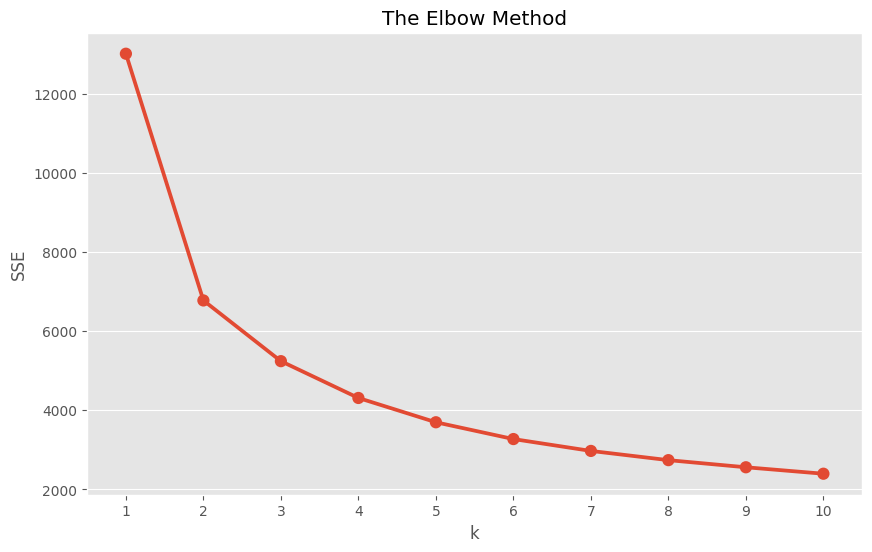

In [10]:

# ==========================================
# 5. FINDING OPTIMAL K (ELBOW METHOD)
# ==========================================
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()



Cluster Summary (Mean Values):
            Recency   Frequency     Monetary  Count
Cluster                                            
1         12.960829  282.894009  7042.565680    868
2         96.380016   80.211302  1518.085579   1221
3         19.894495   38.740826   612.062455    872
0        185.290487   14.968773   298.591097   1377


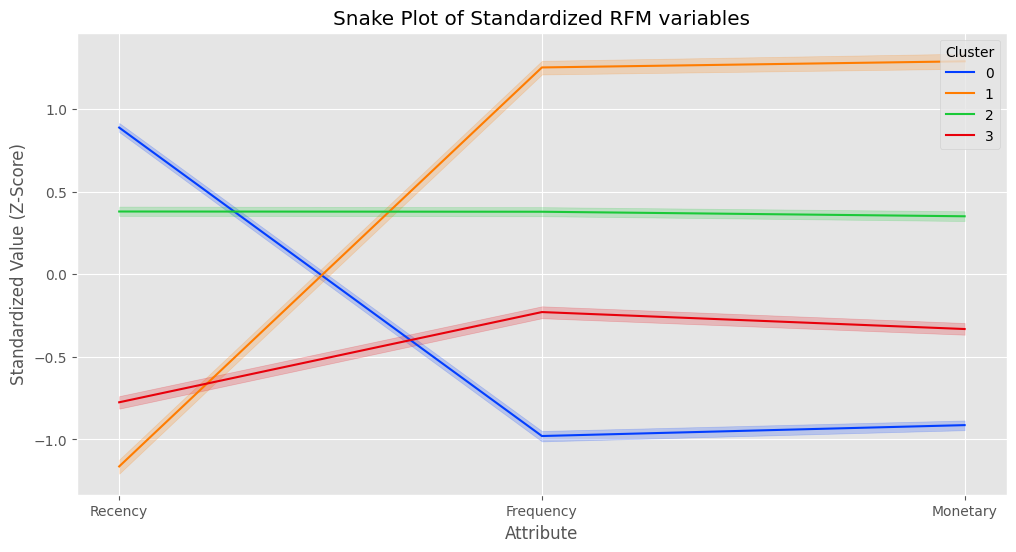


Final Segmentation Distribution:
Segment_Name
Potential Loyalists    1657
Lost/Low Value         1377
Champions               868
At Risk                 436
Name: count, dtype: int64


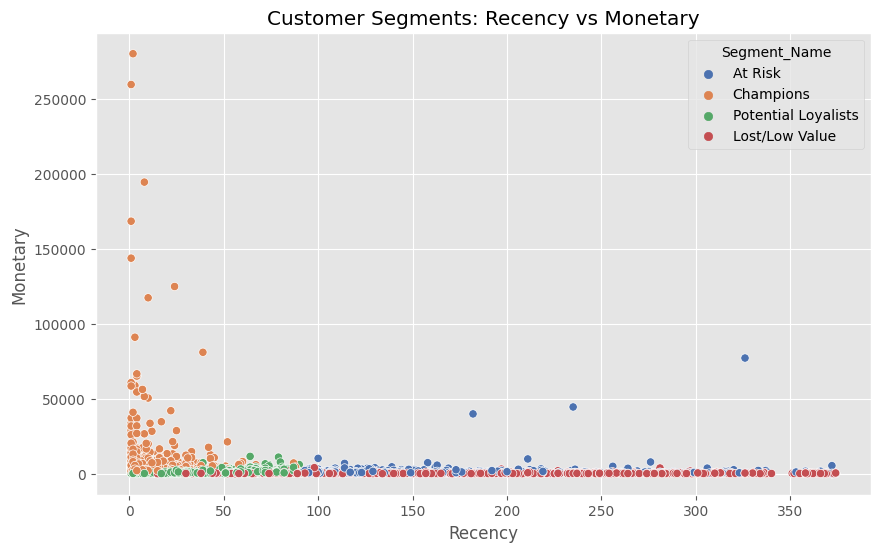

In [11]:
# ==========================================
# 6. MODELING & SEGMENTATION
# ==========================================
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(rfm_normalized)

# Assign clusters back to original data
rfm['Cluster'] = kmeans.labels_

# ==========================================
# 7. INTERPRETATION & VISUALIZATION
# ==========================================

# A. Summary Statistics by Cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'}).sort_values(by='Monetary', ascending=False)

print("\nCluster Summary (Mean Values):")
print(cluster_summary)

# B. Snake Plot (Marketing Standard Visualization) - CORRECTED LOGIC
# 1. Add the Cluster labels to the normalized dataframe first
rfm_normalized_df['Cluster'] = kmeans.labels_

# 2. Reset index so CustomerID becomes a column we can keep
rfm_normalized_df = rfm_normalized_df.reset_index()

# 3. Melt the data (Now including 'Cluster' in id_vars)
rfm_melt = pd.melt(rfm_normalized_df, 
                   id_vars=['CustomerID', 'Cluster'], 
                   value_vars=['Recency', 'Frequency', 'Monetary'], 
                   var_name='Attribute', 
                   value_name='Value')

# 4. Plot
plt.figure(figsize=(12, 6))
plt.title('Snake Plot of Standardized RFM variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=rfm_melt, palette='bright')
plt.ylabel('Standardized Value (Z-Score)')
plt.show()

# ==========================================
# 8. ACTIONABLE INSIGHTS (The "Why")
# ==========================================
def label_customer(row):
    # Logic: High Monetary/Freq + Low Recency = Champions
    if row['Cluster'] == cluster_summary.index[0]: # Highest spender group
        return 'Champions'
    elif row['Cluster'] == cluster_summary.index[-1]: # Lowest spender
        return 'Lost/Low Value'
    elif row['Recency'] > rfm['Recency'].mean():
        return 'At Risk'
    else:
        return 'Potential Loyalists'

rfm['Segment_Name'] = rfm.apply(label_customer, axis=1)

print("\nFinal Segmentation Distribution:")
print(rfm['Segment_Name'].value_counts())

# Scatter Plot Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment_Name', palette='deep')
plt.title('Customer Segments: Recency vs Monetary')
plt.show()